In [12]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [13]:
df = pd.read_csv('location_data.csv', index_col=0)
df.drop('id', axis=1, inplace=True)
print(df)

        latitude  longitude   price
0      38.697500  -9.197680    73.0
1      38.712410  -9.127060   106.0
2      38.711560  -9.129870    75.0
3      38.711080  -9.159790  1065.0
4      38.745710  -9.152640    95.0
...          ...        ...     ...
24259  38.721219  -9.167266  7411.0
24260  38.717077  -9.147289   200.0
24261  38.732713  -9.145716   110.0
24262  38.700770  -9.168950    59.0
24263  38.698704  -9.421072   200.0

[21079 rows x 3 columns]


In [14]:

X = df[['latitude', 'longitude']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)

In [18]:
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_pred, y_test)
rmse = np.sqrt(mse)

print(f"""Model has \n
MSE: {mse}\n
RMSE: {rmse}""")

Model has 

MSE: 296492.74299934536

RMSE: 544.5114718712043


In [61]:

from tqdm import trange

def test_hyperparameters(n_estimators: list, learning_rates: list, max_depths=[]):
    
    if max_depths == []:
        max_depths = [5]
    
    train_rmses = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'rmse'])
    rmses = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'rmse'])
    #rmses = np.zeros([len(n_estimators), len(learning_rates), len(max_depths)])

    for i in trange(len(n_estimators)):
        n_estis = n_estimators[i]
        for j in range(len(learning_rates)):
            for k in range(len(max_depths)):
                max_d = max_depths[k]
                lr = learning_rates[j]
                model = xgb.XGBRegressor(
                    objective='reg:squarederror',
                    n_estimators=n_estis,
                    learning_rate=lr,
                    max_depth=max_d,
                    subsample=0.8,
                    random_state=42
                )
                model.fit(X_train, y_train)

                # train loss
                train_loss = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
                train_rmse = {
                    'n_estimators': n_estis,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'rmse': train_loss
                }
                train_rmse = pd.DataFrame([train_rmse])
                train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)

                # test loss
                y_pred = model.predict(X_test)
                mse = mean_squared_error(y_pred, y_test)
                rmse = np.sqrt(mse)
                rmse = {
                    'n_estimators': n_estis,
                    'learning_rate': lr,
                    'max_depth': max_d,
                    'rmse': rmse
                }
                rmse = pd.DataFrame([rmse])
                rmses = pd.concat([rmses, rmse], ignore_index=True)

    return rmses, train_rmses




In [62]:
n_estimators = [250, 500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000]
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

rmse_df, train_rmses = test_hyperparameters(n_estimators=n_estimators, learning_rates=learning_rates)

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 12/12 [01:58<00:00,  9.88s/it]


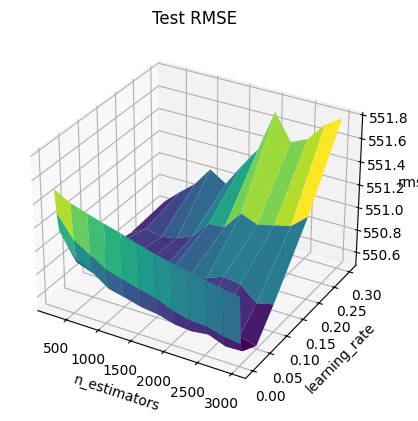

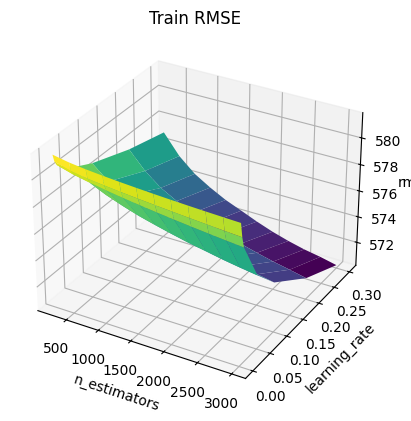

In [69]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_performance(rmse_df, train_rmses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')

    # for plot 1
    x = np.sort(rmse_df['n_estimators'].unique())
    y = np.sort(rmse_df['learning_rate'].unique())
    Z = rmse_df.pivot(index='learning_rate', columns='n_estimators', values='rmse').values

    X, Y = np.meshgrid(x, y)
    X = X.astype(float)
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_title('Test RMSE')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('learning_rate')
    ax.set_zlabel('rmse')


    # for plot 2
    x2 = np.sort(train_rmses['n_estimators'].unique())
    y2 = np.sort(train_rmses['learning_rate'].unique())
    Z2 = train_rmses.pivot(index='learning_rate', columns='n_estimators', values='rmse').values
    X2, Y2 = np.meshgrid(x2, y2)
    X2 = X2.astype(float)
    Y2 = Y2.astype(float)
    ax2.plot_surface(X2, Y2, Z2, cmap='viridis')

    ax2.set_title('Train RMSE')
    ax2.set_xlabel('n_estimators')
    ax2.set_ylabel('learning_rate')
    ax2.set_zlabel('rmse')

    plt.show()

plot_performance(rmse_df, train_rmses)

In [64]:
print(min(rmse_df['rmse']))
print(min(train_rmses['rmse']))

541.9079434906918
378.57244542606657


In [66]:
# training a stump forest
max_depths = [1]

rmse_df, train_rmses = test_hyperparameters(n_estimators=n_estimators, learning_rates=learning_rates, max_depths=max_depths)

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 12/12 [00:32<00:00,  2.73s/it]


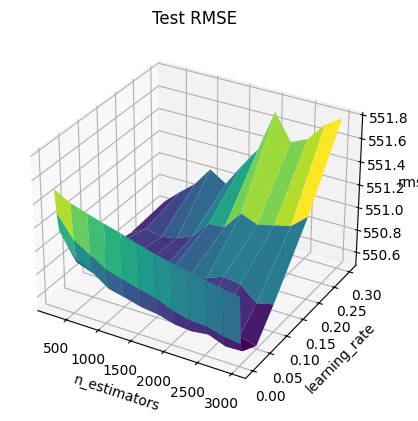

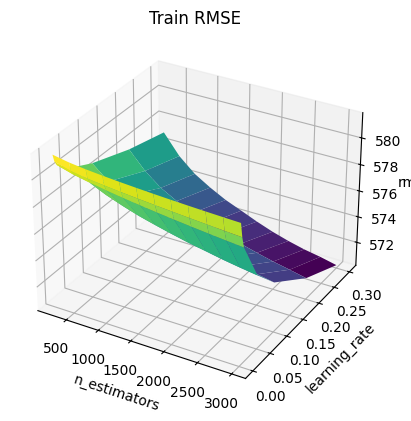

In [70]:
plot_performance(rmse_df, train_rmses)

In [71]:
df = df[df['price'] < 1000]

In [72]:

X = df[['latitude', 'longitude']]
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
rmse_df, train_rmses = test_hyperparameters(n_estimators, learning_rates, max_depths)

  0%|          | 0/12 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 12/12 [00:31<00:00,  2.61s/it]


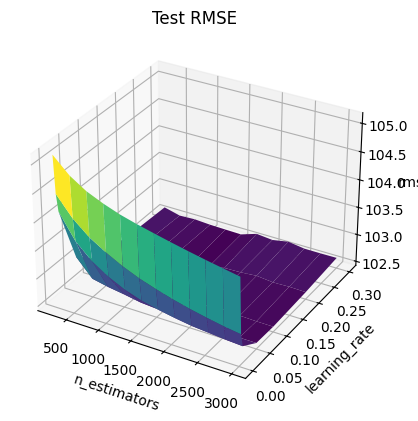

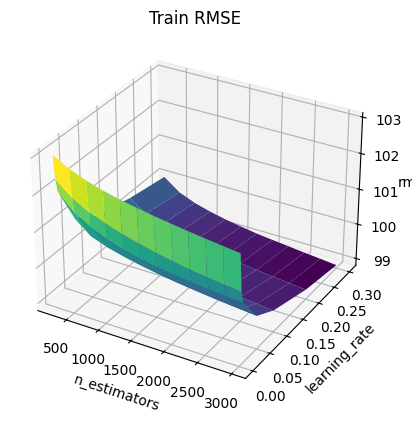

In [74]:
plot_performance(rmse_df, train_rmses)

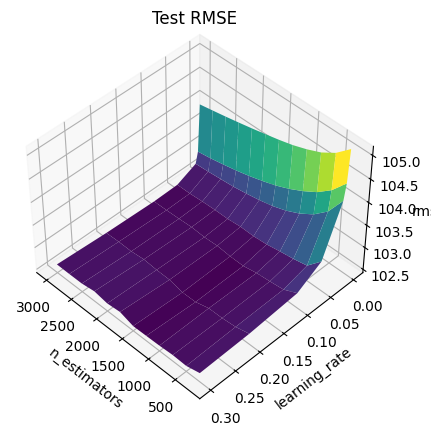

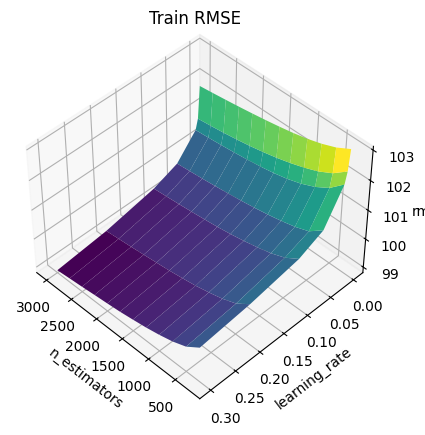

In [75]:
def plot_performance(rmse_df, train_rmses):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')

    # for plot 1
    x = np.sort(rmse_df['n_estimators'].unique())
    y = np.sort(rmse_df['learning_rate'].unique())
    Z = rmse_df.pivot(index='learning_rate', columns='n_estimators', values='rmse').values

    X, Y = np.meshgrid(x, y)
    X = X.astype(float)
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_title('Test RMSE')
    ax.set_xlabel('n_estimators')
    ax.set_ylabel('learning_rate')
    ax.set_zlabel('rmse')
    ax.view_init(elev=45, azim=135)


    # for plot 2
    x2 = np.sort(train_rmses['n_estimators'].unique())
    y2 = np.sort(train_rmses['learning_rate'].unique())
    Z2 = train_rmses.pivot(index='learning_rate', columns='n_estimators', values='rmse').values
    X2, Y2 = np.meshgrid(x2, y2)
    X2 = X2.astype(float)
    Y2 = Y2.astype(float)
    ax2.plot_surface(X2, Y2, Z2, cmap='viridis')

    ax2.set_title('Train RMSE')
    ax2.set_xlabel('n_estimators')
    ax2.set_ylabel('learning_rate')
    ax2.set_zlabel('rmse')
    ax2.view_init(elev=45, azim=135)

    plt.show()

plot_performance(rmse_df, train_rmses)

In [76]:
print(min(rmse_df['rmse']))
print(min(train_rmses['rmse']))

102.48034340425508
98.8872685869112


In [77]:
learning_rates = [0.3]
n_estimators = [5000]
max_depths = [1, 2, 3, 4, 5]

rmse_df, train_rmses = test_hyperparameters(learning_rates=learning_rates, n_estimators=n_estimators, max_depths=max_depths)


  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 1/1 [00:08<00:00,  8.53s/it]


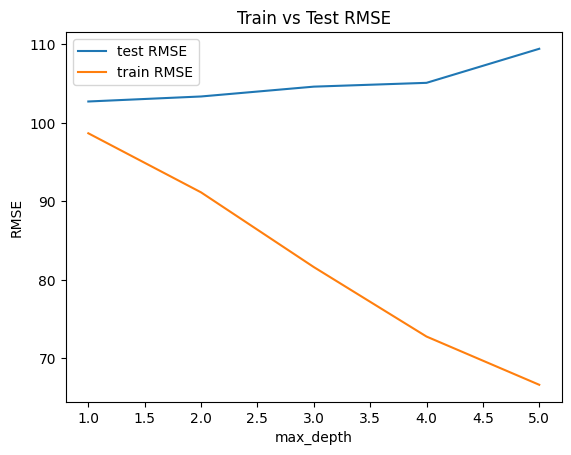

In [84]:
plt.plot(rmse_df['max_depth'], rmse_df['rmse'], label='test RMSE')
plt.plot(train_rmses['max_depth'], train_rmses['rmse'], label='train RMSE')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.title('Train vs Test RMSE')
plt.legend()
plt.show()

In [85]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.3]
n_estimators = [5000]
max_depths = [1, 2, 3, 4, 5]

rmse_df, train_rmses = test_hyperparameters(learning_rates=learning_rates, n_estimators=n_estimators, max_depths=max_depths)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 1/1 [00:50<00:00, 50.08s/it]


In [97]:
def plot_performance(rmse_df, train_rmses, labels):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')

    label_1, label_2 = labels

    # for plot 1
    x = np.sort(rmse_df[label_1].unique())
    y = np.sort(rmse_df[label_2].unique())
    Z = rmse_df.pivot_table(index=label_2, columns=label_1, values='rmse', aggfunc='mean').values
    Z = Z.astype(float)
    X, Y = np.meshgrid(x, y)
    Y = Y.astype(float)
    X = X.astype(float)
    ax.plot_surface(X, Y, Z, cmap='viridis')

    ax.set_title('Test RMSE')
    ax.set_xlabel(label_1)
    ax.set_ylabel(label_2)
    ax.set_zlabel('rmse')
    ax.view_init(elev=45, azim=135)


    # for plot 2
    x2 = np.sort(train_rmses[label_1].unique())
    y2 = np.sort(train_rmses[label_2].unique())
    Z2 = train_rmses.pivot_table(index=label_2, columns=label_1, values='rmse', aggfunc='mean').values
    X2, Y2 = np.meshgrid(x2, y2)
    Z2 = Z2.astype(float)
    X2 = X2.astype(float)
    Y2 = Y2.astype(float)
    ax2.plot_surface(X2, Y2, Z2, cmap='viridis')

    ax2.set_title('Train RMSE')
    ax2.set_xlabel(label_1)
    ax2.set_ylabel(label_2)
    ax2.set_zlabel('rmse')
    ax2.view_init(elev=45, azim=135)

    plt.show()


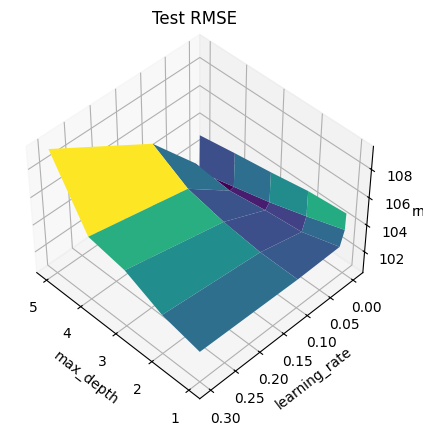

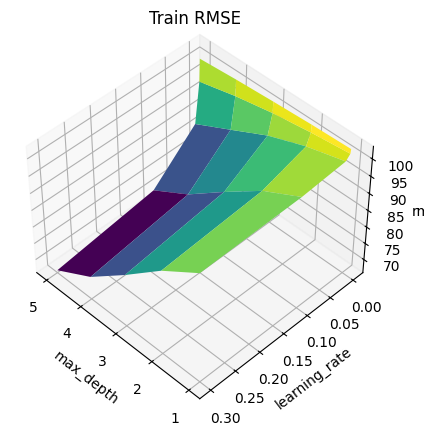

In [87]:
plot_performance(rmse_df, train_rmses, ['max_depth', 'learning_rate'])

It is good to have low learning rate with high max depth

In [88]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.00025, 0.0005]
n_estimators = [5000]
max_depths = [1, 2, 3, 4, 5]

rmse_df, train_rmses = test_hyperparameters(learning_rates=learning_rates, n_estimators=n_estimators, max_depths=max_depths)

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 1/1 [00:49<00:00, 49.54s/it]


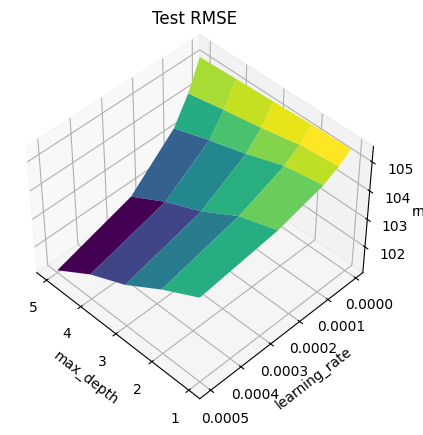

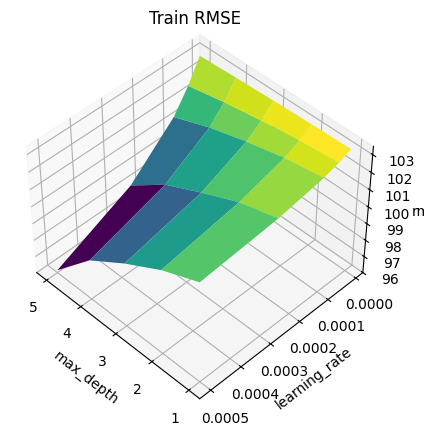

In [89]:
plot_performance(rmse_df, train_rmses, ['max_depth', 'learning_rate'])

In [90]:
learning_rates = [0.00001, 0.00005, 0.0001, 0.00025, 0.0005]
n_estimators = [5000, 7500, 10000]
max_depths = [1, 2, 3, 4, 5]

rmse_df, train_rmses = test_hyperparameters(learning_rates=learning_rates, n_estimators=n_estimators, max_depths=max_depths)

  0%|          | 0/3 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\4033425263.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 3/3 [05:59<00:00, 119.86s/it]


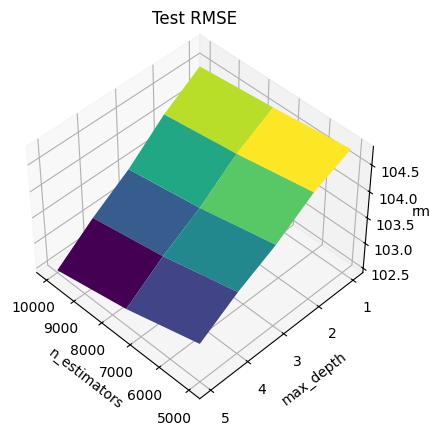

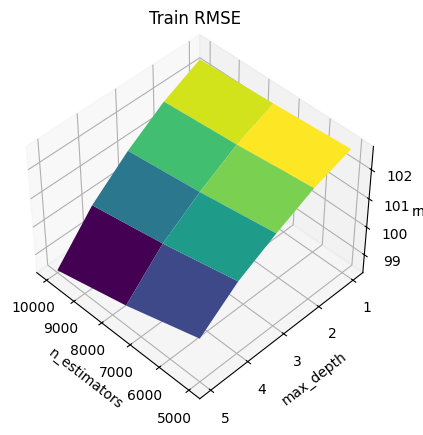

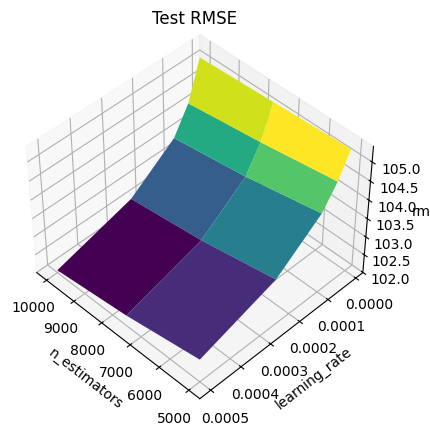

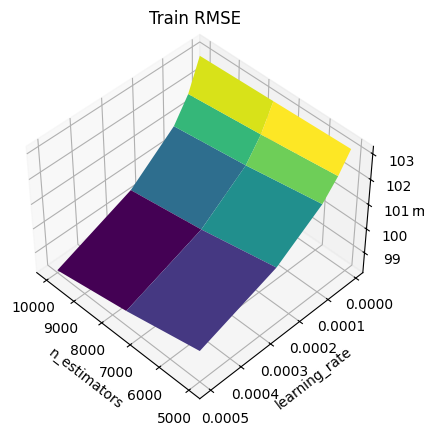

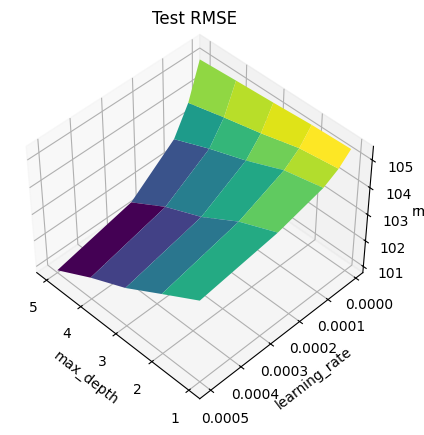

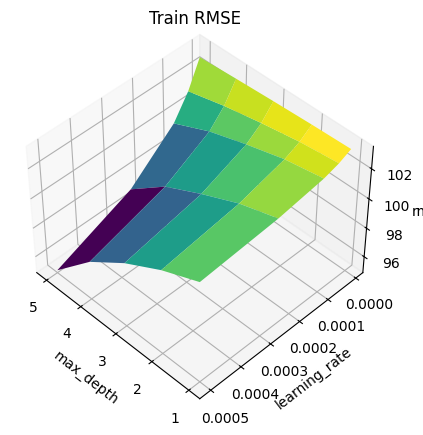

In [98]:
plot_performance(rmse_df, train_rmses, ['n_estimators', 'max_depth'])
plot_performance(rmse_df, train_rmses, ['n_estimators', 'learning_rate'])
plot_performance(rmse_df, train_rmses, ['max_depth', 'learning_rate'])

In [ ]:
print(min(rmse_df['rmse']))
print(min(train_rmses['rmse']))

Let's try some normal regularization!

In [94]:

from tqdm import trange

def test_hyperparameters(n_estimators: list, learning_rates: list, regularizers: list, max_depths=[]):
    
    if max_depths == []:
        max_depths = [5]
    
    train_rmses = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'rmse'])
    rmses = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'max_depth', 'rmse'])
    #rmses = np.zeros([len(n_estimators), len(learning_rates), len(max_depths)])

    for i in trange(len(n_estimators)):
        n_estis = n_estimators[i]
        for j in range(len(learning_rates)):
            lr = learning_rates[j]
            for k in range(len(max_depths)):
                max_d = max_depths[k]
                for h in range(len(regularizers)):
                    regularization = regularizers[h]
                    model = xgb.XGBRegressor(
                        objective='reg:squarederror',
                        n_estimators=n_estis,
                        learning_rate=lr,
                        max_depth=max_d,
                        gamma=regularization,
                        subsample=0.8,
                        random_state=42
                    )
                    model.fit(X_train, y_train)

                    # train loss
                    train_loss = np.sqrt(mean_squared_error(y_train, model.predict(X_train)))
                    train_rmse = {
                        'n_estimators': n_estis,
                        'learning_rate': lr,
                        'max_depth': max_d,
                        'regularization': regularization,
                        'rmse': train_loss
                    }
                    train_rmse = pd.DataFrame([train_rmse])
                    train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)

                    # test loss
                    y_pred = model.predict(X_test)
                    mse = mean_squared_error(y_pred, y_test)
                    rmse = np.sqrt(mse)
                    rmse = {
                        'n_estimators': n_estis,
                        'learning_rate': lr,
                        'max_depth': max_d,
                        'regularization': regularization,
                        'rmse': rmse
                    }
                    rmse = pd.DataFrame([rmse])
                    rmses = pd.concat([rmses, rmse], ignore_index=True)

    return rmses, train_rmses




In [100]:
gammas = [0, 0.1, 0.5, 1, 2, 5, 10]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
n_estimators = [1000, 2500, 5000, 7500, 10000]
max_depths = [1, 3, 5, 7, 10]

rmse_df, train_rmses = test_hyperparameters(
    n_estimators=n_estimators,
 learning_rates=learning_rates,
 regularizers=gammas,
 max_depths=max_depths
 )

  0%|          | 0/5 [00:00<?, ?it/s]C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\3263260946.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_rmses = pd.concat([train_rmses, train_rmse], ignore_index=True)
C:\Users\luigi\AppData\Local\Temp\ipykernel_9840\3263260946.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  rmses = pd.concat([rmses, rmse], ignore_index=True)
100%|██████████| 5/5 [59:49<00:00, 717.80s/it]


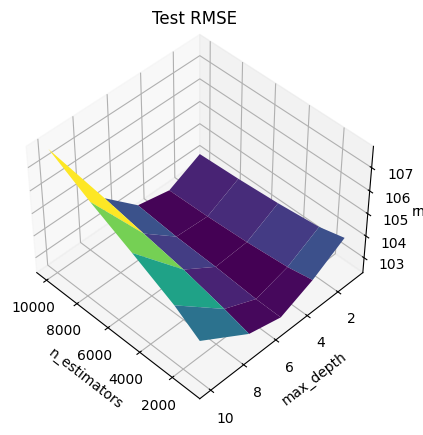

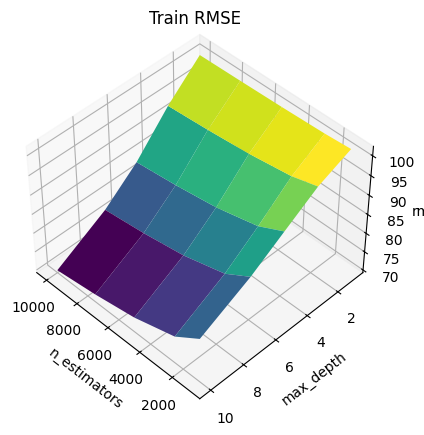

In [101]:
plot_performance(rmse_df, train_rmses, ['n_estimators', 'max_depth'])

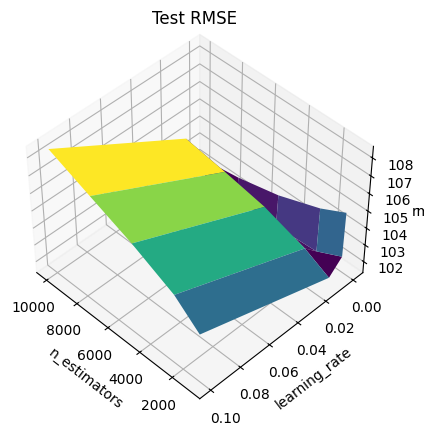

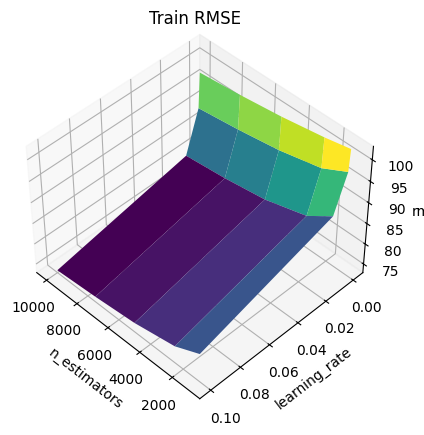

In [102]:

plot_performance(rmse_df, train_rmses, ['n_estimators', 'learning_rate'])

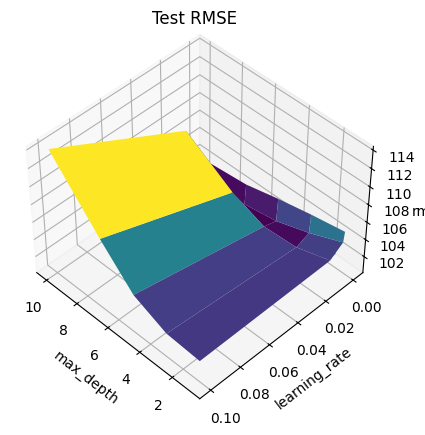

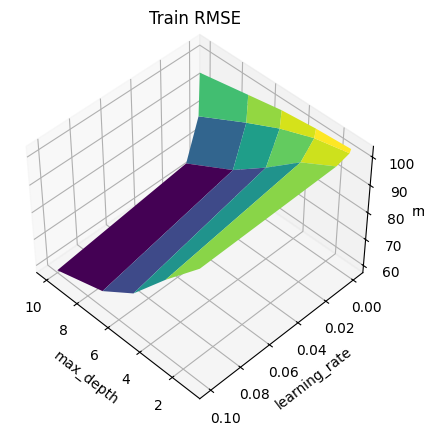

In [103]:
plot_performance(rmse_df, train_rmses, ['max_depth', 'learning_rate'])

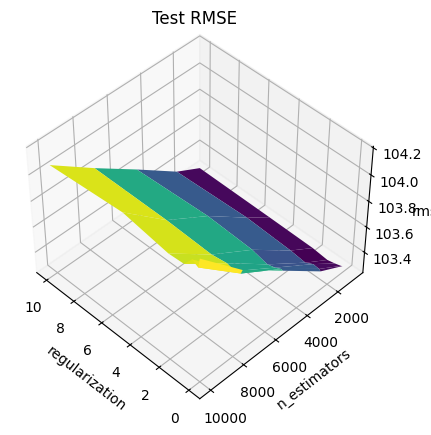

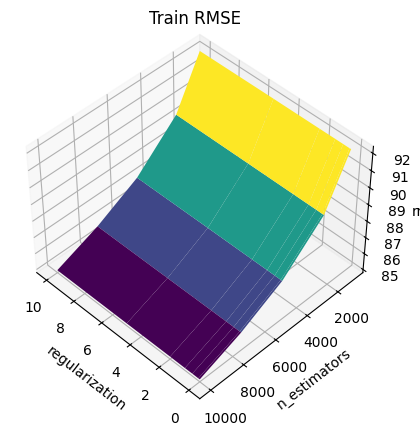

In [104]:
plot_performance(rmse_df, train_rmses, ['regularization', 'n_estimators'])

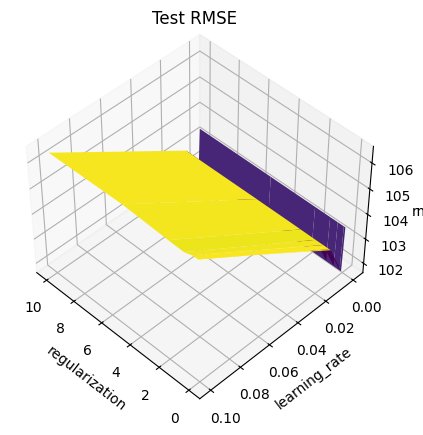

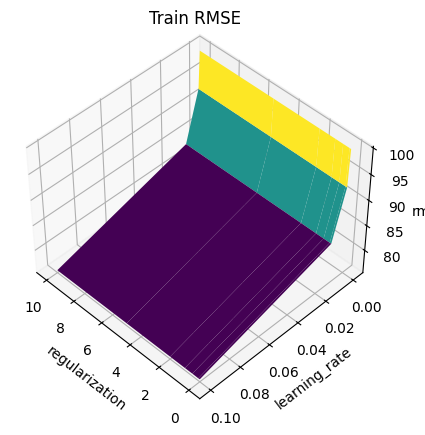

In [105]:
plot_performance(rmse_df, train_rmses, ['regularization', 'learning_rate'])

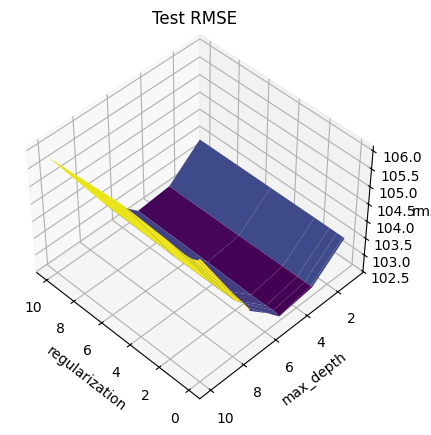

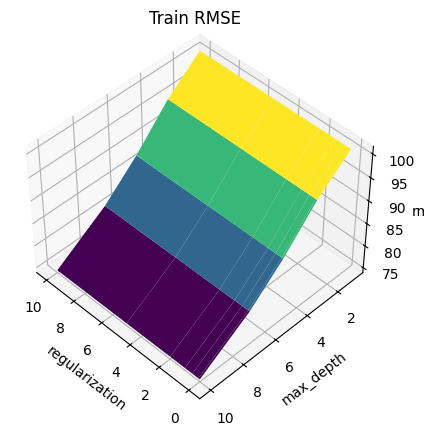

In [106]:
plot_performance(rmse_df, train_rmses, ['regularization', 'max_depth'])